# Methods for Data Science: Course Work 1

## Task 1:  Regression (50 marks)



#### 1.1 Linear regression (8 marks)  

1.1.1

In [3]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from collections import defaultdict


def pred(X, beta):
    return np.matmul(X, beta)

def residuals(y, y_pred):
    return y - y_pred

def RSS(y, y_pred):
    return np.dot(residuals(y, y_pred), residuals(y, y_pred))

def MSE(y, y_pred):
    N = len(y)
    return 1/N * RSS(y, y_pred)

def Rsquare(y, y_pred):
    ybar = np.mean(y)
    RSS0 = RSS(y, ybar)
    return 1 - RSS(y, y_pred)/RSS0

def standardise(X):
    mu = np.mean(X, 0)
    sigma = np.std(X, 0)
    X_std = (X - mu) / sigma 
    return X_std, mu, sigma

#values for all models to be made into a table
MSE_list_models = []
R_square_list_models = []
model_list = []

Below we will find a linear relationship between the predictor variables and the output variable.

In [495]:
#Loading in the data
airfoil_noise_samples = pd.read_csv("airfoil_noise_samples.csv")
N = len(airfoil_noise_samples)
y = np.array(airfoil_noise_samples["Sound Pressure"])
X = np.array(airfoil_noise_samples)[:, 0:-1]
X , mu, sigma = standardise(X)
#Adding a coloumn of ones to represent an intercept 
X = np.c_[np.ones(N), X]

#The loss function is a constant multiple of the RSS, to minimise this we use the least squares estimation
def least_squares(Y, X):
    XtX = np.matmul(np.transpose(X), X)
    XtY = np.dot(np.transpose(X), Y)
    betahat = np.linalg.solve(XtX, XtY)
    return betahat


betahat = least_squares(y, X)
y_pred = pred(X, betahat)
MSE_list_models.append(MSE(y, y_pred))
R_square_list_models.append(Rsquare(y, y_pred))
model_list.append("Least Squares training")
print(MSE(y, y_pred))
print(Rsquare(y, y_pred))



1.8755566396402035
0.9177343977263076


1.1.2

In [496]:
airfoil_noise_test = pd.read_csv("airfoil_noise_test.csv")
X_test = np.array(airfoil_noise_test.drop("Sound Pressure", axis = "columns"))
y_test = np.array(airfoil_noise_test["Sound Pressure"])
N = len(y_test)
#X_test needs to be standardised using the same mean and sd as the training data
X_test = (X_test- mu)/sigma
X_test = np.c_[np.ones(N), X_test]

y_pred_test = pred(X_test, betahat)
MSE_list_models.append(MSE(y_test, y_pred_test))
R_square_list_models.append(Rsquare(y_test, y_pred_test))
model_list.append("Least Squares test")
print(MSE(y_test, y_pred_test))
print(Rsquare(y_test, y_pred_test))

1.9843895771191615
0.9083172459581621


Here we have standardised the data as it gives us the ability to better compare beta estimate values. It also has relevance since the variables have different units of measurements such as displacement and frequency. Importantly we also minimize the impact of outliers, which are extreme values that may skew the results of the model. This step improves the robustness of the models and so we will continue to use the standardised data for all of the models in this coursework. 

We see that the MSE for our training data is smaller than the MSE for the test set, this means that on average we have better estimates for the training data. In general we would expect the training set to outperfom the test set unless our model is underfitting since we learn the values from the training set, however if the MSE of the test set is much higher than the test set it would suggest that we are overfitting the model with too many parameters and so we are fitting some of the noise in the training data. To tackle this issue we could consider running hypothesis test on the variables or calculate our covariance matrix to see which parameters may be correlated and then consider removing these and refitting the model. We would then expect more similar values of MSE for the training and test data. 

Analysing the R^2 score we see that is is close to 1 which is a good indicator that the model is explaining variability in the data and since our R^2 for the test and training set are close to 1 we see that we are doing a good job of fitting the model. A downside to the vanilla R^2 statistic is that it does not account for the number of parameters in the model and so we could instead compute the adjusted R^2 statistic for the model and compare it to models with fewer variables to get a better understanding of the model performance combined with its simplicity. 

#### 1.2 Lasso regression (12 marks) 

1.2.1

Below we will try to optimise the predicted values of beta by considering the bias-variance tradeoff using a lasso regression shrinkage method.

In [497]:
def lasso(Y, X, beta, l = 0.01):
    N = len(Y)
    Y_pred = pred(X, beta)
    lasso = (RSS(Y, Y_pred))/(2*N) + l*np.sum(abs(beta[1:]))
    return lasso

def grad(Y, X, beta, l):
    N = len(Y)
    XtY = np.matmul(np.transpose(X), Y)
    XtX = np.matmul(np.transpose(X), X)
    #Removing beta0 from the regularisation
    betanew = list(np.sign(beta[1:]))
    betanew.insert(0,0)
    d = -1*(XtY - np.dot(XtX, beta))/N + l*np.array(betanew)
    return d

#A function to add into the stopping criteria 
def lasso_diff(Y, X, beta, step, d, l):
    return abs((lasso(Y, X, beta, l) - lasso(Y, X, beta + step*d, l))/lasso(Y, X, beta, l))

def grad_descent(Y, X, beta, l):
    step = 1
    d = -1 * grad(Y, X, beta, l)
    counter = 1
    #10,000 iterations unless the difference in loss is minimal
    while (counter < 1000) and lasso_diff(Y, X, beta, step, d, l) > 1e-8:
        beta = beta + step*d
        #Descent diretion
        d = -1 * grad(Y, X, beta, l)
        counter += 1
        #Step size proportional to the number of iterations
        step = 10/counter
    return beta

#Cross Validation 
def cross_val(Y, X, folds, train_func, performance, l, *args, k=5):
    score = 0
    for i in range(len(folds)):
        #One of the folds picked as a validation set
        val_indexes = folds[i]
        #The rest of the folds are left as training sets
        train_indexes = list(set(range(Y.shape[0])) - set(val_indexes))
        
        X_train_i = X[train_indexes, :]
        y_train_i = Y[train_indexes]

        X_val_i = X[val_indexes, :] 
        y_val_i = Y[val_indexes] 

        beta = train_func(y_train_i, X_train_i, np.ones(7), l, *args)
        Y_pred = pred(X_val_i, beta)
        perform_val = performance(y_val_i, Y_pred) 
        score += perform_val
    # Return the average score
    return score/len(folds)



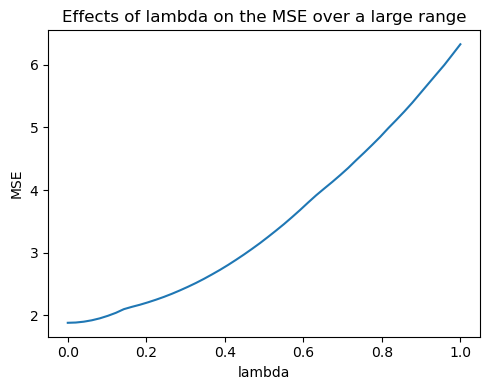

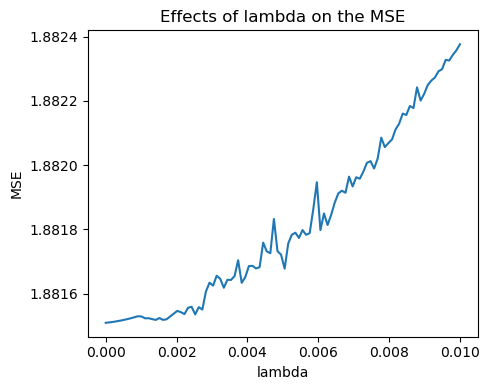

In [498]:
folds_indexes = np.split(np.random.permutation(np.arange(len(y))), 5)

#Testing a range of values for lambda to find an optimal neighbourhood
lambda_vals_ranged = np.linspace(0, 1, 50)
MSE_vals_ranged = []
for l in lambda_vals_ranged:
    MSE_vals_ranged.append(cross_val(y, X, folds_indexes, grad_descent, MSE, l))

#Testing an optimal neighbourhood about 0 
lambda_vals = np.linspace(0, 0.01, 100)
MSE_vals = []
for l in lambda_vals:
    MSE_vals.append(cross_val(y, X, folds_indexes, grad_descent, MSE, l))

#Plot for a large range of lambda
plt.figure()
plt.plot(lambda_vals_ranged, MSE_vals_ranged)
plt.title("Effects of lambda on the MSE over a large range")
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.show()

#Plot for smaller neighbourhood of lambda
plt.figure()
plt.plot(lambda_vals, MSE_vals)
plt.title("Effects of lambda on the MSE")
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.show()



From the first plot above we see that the value of lambda which minimises the loss function must be in some neighbourhood around 0 and so we rerun the process on values of lambda closer to 0 at a higher resolution to find this minimum. We can then identify the optimal value of lambda from the minimum point on the graph. (Note that this value of lambda is varying when we permute the data set)

1.2.2

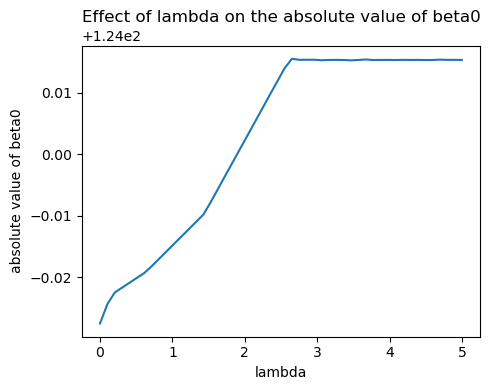

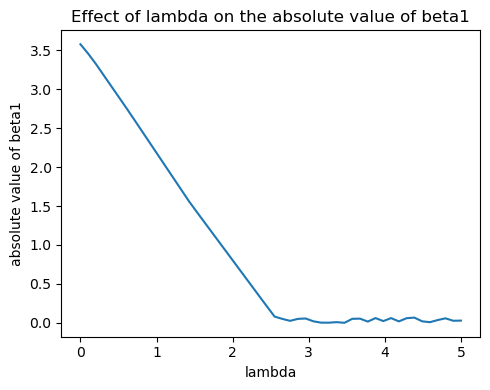

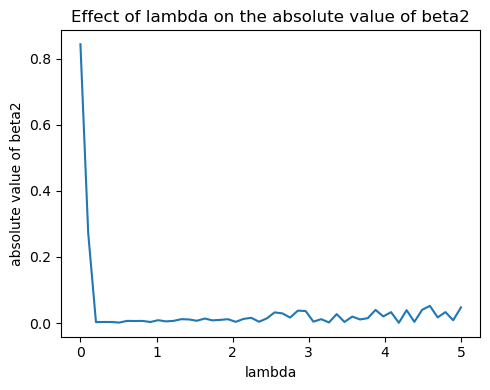

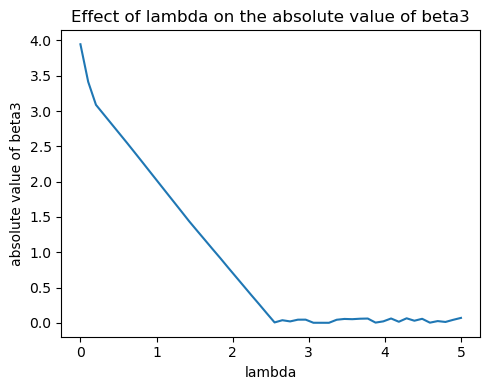

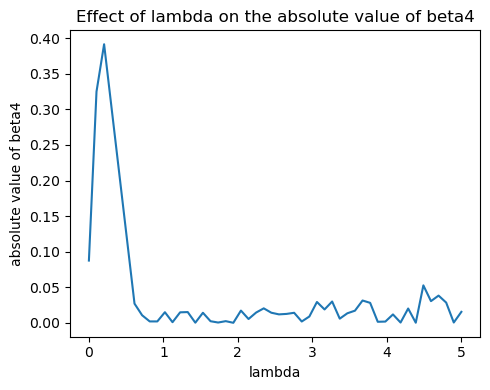

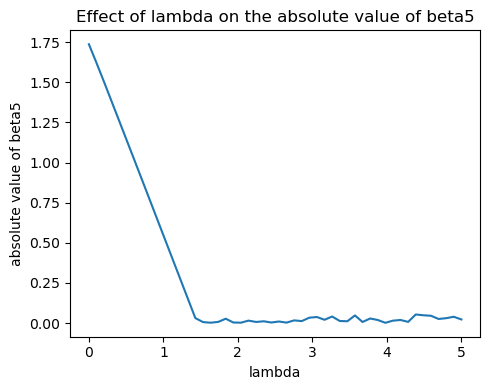

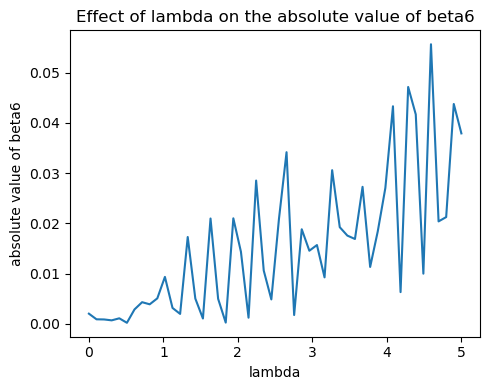

In [499]:
#One of the folds picked as a validation set
val_indexes = folds_indexes[0]
#The rest of the folds are left as training sets
train_indexes = list(set(range(y.shape[0])) - set(val_indexes))
X_train = X[train_indexes, :]
y_train = y[train_indexes]



varying_lambda = np.linspace(0, 5, 50)
beta_vals = []
for l in varying_lambda:
    beta_vals.append(grad_descent(y_train, X_train, np.ones(7), l))
beta_vals = np.array(np.abs(beta_vals))

for j in range(7):
    plt.figure()
    plt.plot(varying_lambda, beta_vals[:, j])
    plt.title(f"Effect of lambda on the absolute value of beta{j}")
    plt.xlabel("lambda")
    plt.ylabel(f"absolute value of beta{j}")
    plt.show()


The graphs above show the effect of lambda on the absolute values of beta. From each of these we see that we are approaching zero or at least hovering around it. This is because the loss function is increasingly punishing the function for having large absolute values for the beta values, with an exception for beta 6 likely because it describes the y variable well and so contributes to minimising the least squares term more than its effect on the lasso term or it could simply be that we are not stopping too early in our gradient descent function or our step size is too large which can be easily remedied by increasing the counter (more iterations) or using a step size which decreases when we overshoot the minimum. 

Using the lasso shrinkage term the goal is to reduce variance in the model from training which is a symptom of an overly complex and overfitting model so that it can generalise well to unseen data. This ends up increasing the bias of the model as we are no longer using an unbiased estimator. The MSE is (in general) increasing and this is due to the fact that after a point the benefit of reducing the variance is being lost to having the bias increasing so our estimates of y are consistently off. The optimal value is found through cross validation and is the value which generalises best to unseen data i.e the validation set. As lambda gets larger and larger we end up converging to the null model (with an exception on the value of beta 0) since this is the model which maximally minimises the variance since there is no variance in estimates if all values are 0. 

1.2.3

optimal lambda  0.0


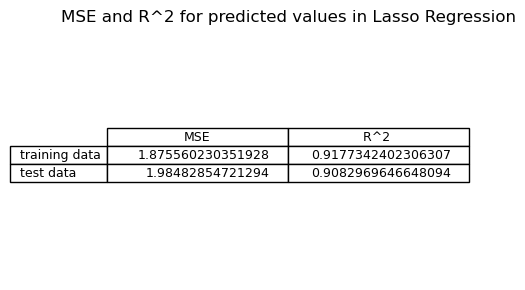

In [500]:
#Optimal one minimises the MSE
a = MSE_vals.index(min(MSE_vals))
print("optimal lambda ", lambda_vals[a])

#Results from MSE
beta_lasso = grad_descent(y, X, np.ones(7), lambda_vals[a])
y_pred1 = pred(X, beta_lasso)
y_pred1_test = pred(X_test, beta_lasso)
MSE_preds = np.array((MSE(y, y_pred1),MSE(y_test, y_pred1_test)))
R_preds = np.array((Rsquare(y, y_pred1),Rsquare(y_test, y_pred1_test) ))

MSE_list_models.append(MSE(y, y_pred1))
R_square_list_models.append(Rsquare(y, y_pred1))
model_list.append("Lasso Regression training")

MSE_list_models.append(MSE(y_test, y_pred1_test))
R_square_list_models.append(Rsquare(y_test, y_pred1_test))
model_list.append("Lasso Regression test")

plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.transpose(np.array((MSE_preds, R_preds)))
columns = ("MSE", "R^2 ")
rows = ("training data", "test data")
axs.axis('tight')
axs.axis('off')
axs.set_title("MSE and R^2 for predicted values in Lasso Regression")
the_table = axs.table(cellText=data, colLabels=columns, rowLabels = rows, loc='center')
plt.show()

We see that their is an increase to the MSE from the training set to the test set however its relative effect on predictivity of the model isnt too noticeable (can be seen from R^2 value). If we had used lambda=0 we would be numerically calculating the least squares estimator however the value of lambda instead slightly reduces the size of the beta estimates (in general), this can be seen in the plots used in 1.2.2 where a larger lambda brings values to 0. In the case of beta4 we actually increase in absolute value when we have lambda close to 0 and this is because the loss is maximally reduced by improving the least squares term rather than a small change in the value of the coefficient. Note also that the trend of values to zero would be much more drastic for non-standardised data. 

From lambda=0 we have reduced some variability in the model and in doing so added some bias to the model however if we compare R^2 values for the optimal lambda and lambda=0 i.e the least squares estimate, then we see that our R^2 has actually improved. 

#### 1.3 Elastic Nets (20 marks) 
1.3.1

Here we have considered the elastic nets function as it will help us consider whether or not a ridge regression term will perform well for the data set. It could be that a combination of the two performs best. 

In [501]:
#Indexes for the folds 
folds_indexes = np.split(np.random.permutation(np.arange(len(y))), 5)

def elastic(Y, X,  beta, l=0.01, alpha = 0.01):
    #returns value of elastic nets function
    Y_pred = pred(X, beta)
    return RSS(Y, Y_pred)/2*N + l*(alpha*np.sum(beta[1:]) + (1-alpha)*np.sqrt(np.dot(beta[1:], beta[1:])))

#Stopping function similar to that in lasso
def nets_diff(Y, X, beta, step, d, l, alpha):
    return abs(elastic(Y, X, beta, l, alpha) - elastic(Y, X, beta + step*d, l, alpha))

def grad2(Y, X, beta, l, alpha = 0.1):
    #Gradient of elastic nets
    N = len(Y)
    XtY = np.matmul(np.transpose(X), Y)
    XtX = np.matmul(np.transpose(X), X)
    #Beta0 term not included in the shrinkage
    betanew = list((beta[1:]))
    betanew.insert(0, 0)
    betanew = np.array(betanew)
    d = -1*(XtY - np.dot(XtX, beta))/N + l*(alpha * np.sign(betanew) + 2*(1-alpha)*(betanew))
    return d

def grad_descent2(Y, X, beta, l, alpha):
    #Gradient descent applied to elastic nets loss function
    step = 1
    d = -1 * grad2(Y, X, beta, l)
    counter = 1
    #10,000 iterations unless the difference in loss is minimal
    while (counter < 1000) and nets_diff(Y, X, beta, step, d, l, alpha) > 1e-8:
        beta = beta + step*d
        d = -1 * grad2(Y, X, beta, l, alpha)
        counter += 1
        step = 10/counter
    return beta

#grad_descent2(Y, Xst, np.ones(7), l=0.1, alpha = 0.5)
def grid_search_EN(y, X, folds, train_func, performance, lambda_vals, alpha_vals, k=5):
    best_vals = []
    best_val = 10
    #Loop over values of lambda for each value of alpha
    for a in alpha_vals:
        for l in lambda_vals:
            #Score for a given (l, a)
            perform_val = cross_val(y, X, folds, train_func, performance, l, a, k=5)
            #update to find smallest MSE
            if perform_val < best_val:
                best_val = perform_val
                best_l = l
        #Save the score and the best lambda for each alpha
        best_vals.append([best_val, a, best_l])
        #Reset the score to something high
        best_val = 10
    return best_vals


alpha_vals = np.array((0.1, 0.5, 0.9))
EN_lambda_vals = np.linspace(0, 0.01, 201)
optimal_values_EN = grid_search_EN(y, X, folds_indexes, grad_descent2, MSE, EN_lambda_vals, alpha_vals)


1.3.2

In [502]:
beta_01 = grad_descent2(y, X, np.ones(7), optimal_values_EN[0][2], 0.1)
beta_05 = grad_descent2(y, X, np.ones(7), optimal_values_EN[1][2], 0.5)
beta_09 = grad_descent2(y, X, np.ones(7), optimal_values_EN[2][2], 0.9)

#Optimal lambda and alpha predicted on the training set
EN_y_pred = pred(X, beta_09)

#all alpha predicted on test set with optimal lambda
y_pred_01 = pred(X_test, beta_01)
y_pred_05 = pred(X_test, beta_05)
y_pred_09 = pred(X_test, beta_09)

print(f"MSE and R^2 for alpha 0.1 and lambda {optimal_values_EN[0][2]} respectively:", MSE(y_test, y_pred_01),", ", Rsquare(y_test, y_pred_01))
print(f"MSE and R^2 for alpha 0.5 and lambda {optimal_values_EN[1][2]} respectively:", MSE(y_test, y_pred_05), ", " , Rsquare(y_test, y_pred_05) )
print(f"MSE and R^2 for alpha 0.9 and lambda {optimal_values_EN[2][2]} respectively:", MSE(y_test, y_pred_09), ", ", Rsquare(y_test, y_pred_09))

EN_MSE, alpha_vals, EN_lambda_vals = tuple(zip(*optimal_values_EN))


MSE_list_models.append(MSE(y, EN_y_pred))
R_square_list_models.append(Rsquare(y, EN_y_pred))
model_list.append("Elastic Nets training")

MSE_list_models.append(MSE(y_test, y_pred_09))
R_square_list_models.append(Rsquare(y_test, y_pred_09))
model_list.append("Elastic Nets test")


MSE and R^2 for alpha 0.1 and lambda 0.0001 respectively: 1.9848933591107791 ,  0.9082939702259366
MSE and R^2 for alpha 0.5 and lambda 0.00030000000000000003 respectively: 1.9851139304560144 ,  0.9082837793901113
MSE and R^2 for alpha 0.9 and lambda 0.0016 respectively: 1.9851077097671472 ,  0.908284066798337


Notice that as our values of alpha increase, then so do our optimal values of lambda. This means that as we use less and less of the ridge regression term we actually increase the contribution from the overall shrinkage term meaning that the model favours lasso for this data set. 

1.3.3

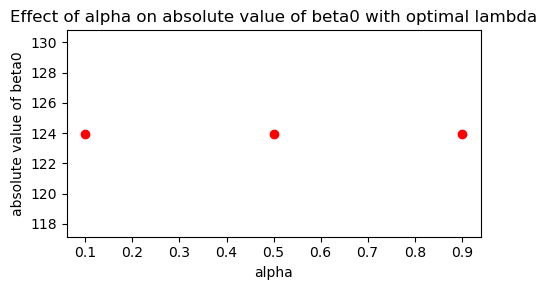

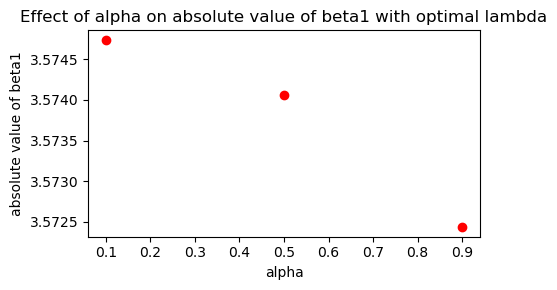

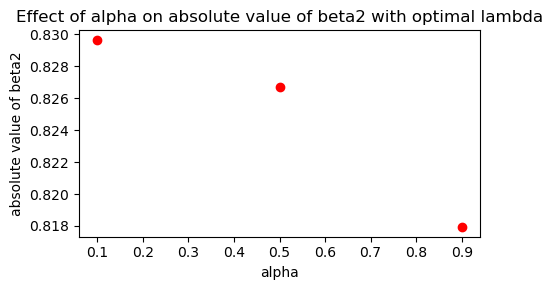

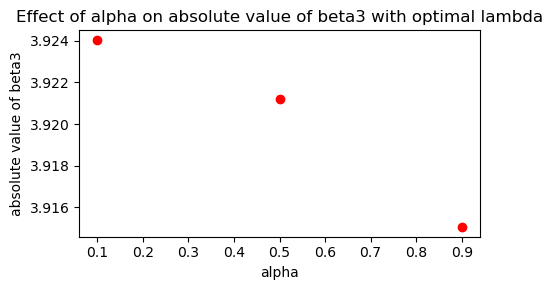

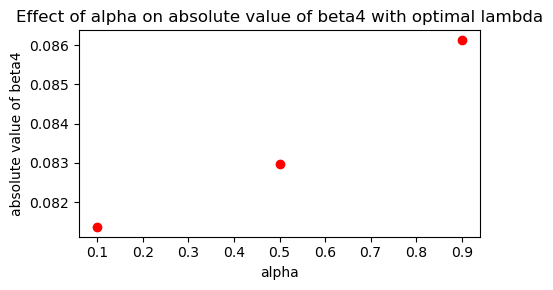

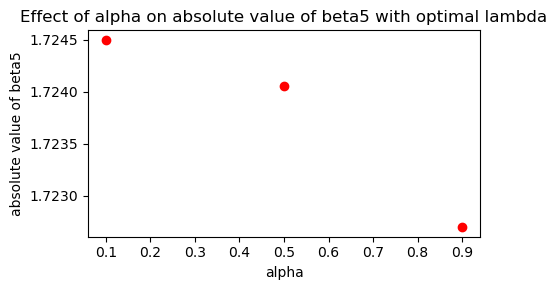

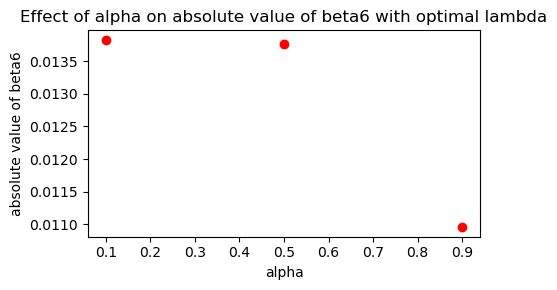

In [503]:
for i in range(7):
    plt.figure()
    plt.plot(alpha_vals, np.array(np.abs((beta_01[i],beta_05[i], beta_09[i]))), "ro")
    plt.xlabel("alpha")
    plt.ylabel(f"absolute value of beta{i}")
    plt.title(f"Effect of alpha on absolute value of beta{i} with optimal lambda")


Clearly the optimal alpha value is alpha = 0.9 as it has the largest R^2 and lowest MSE between itself and the other tested alpha parameters. For this given alpha we would use a lambda value of approximately 0.00165. Note that this improvement between itself and the other alpha values is incredibly small meaning that the lasso term is favoured over the ridge term however the improvement from this optimisation is minimal. 

In the case where alpha = 0 we have no contribution from the 1-norm term in the loss function and so we are actually performing  the ridge regression function. For alpha 0.5 we have an equal contribution from both the 1-norm and the 2-norm meaning they share equal importance when minimising the loss function. Since the 1-norm is known for introducing sparsity more strongly than the 2-norm does this is essentially a balancing act between bringing values to 0 and lowering their absolute value. Finally letting alpha to be 1 is no different then the lasso regression we did earlier as the 2-norm has 0 contribution and we would expect the optimal values of alpha amd lambda to multiply to the optimal value of lambda from the lasso function. 

From the plots we see that generally the absolute value of the beta value is decreasing as alpha increases and this is again due to the lasso function implementing scarsity stronger than the ridge regression. 

#### 1.4 kNN regression (10 marks)
1.4.1

It is incredibly important to standardise the data for KNN regression as we are calculating distances from points and we do not want some predictor variables to have a dominant effect on the distance. For this reason we ensure we are using standardised data so that each predictor variable has an equal effect on the distance. 

For KNN regression we are trying to find non-linear relationships between the data and the predictor variables and so if this regression technique performs the best than we can assume that we are not accounting for a non-linear relationship in the data under least squares estimation. 

Text(0.5, 1.0, 'R^2 score for varying values of K')

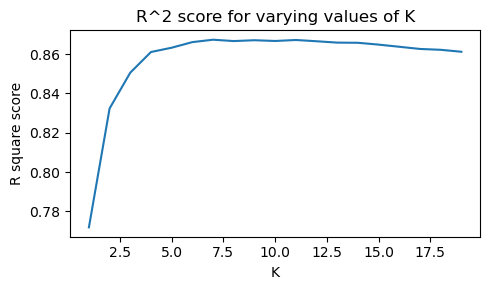

In [504]:
#Euclidean Distance
def distance(p, q):
    return np.sqrt(np.sum((p-q)**2, axis=1))


def predict(X_train, y_train, X_test, k=5):
  neighbours = k_neighbours(X_train, X_test, k=k)
  y_pred = [np.mean(y_train[neighbour]) for neighbour in neighbours]
  return y_pred


def score(X_train, y_train, X_test, y_test, k=5):
  y_pred = predict(X_train, y_train, X_test, k=k) 
  return Rsquare(y_test, y_pred)


def k_neighbours(X_train, X_test, k=5, return_distance=False):
  n_neighbours = k
  dist = []
  neigh_ind = []
  
  # compute distance from each point x_test in X_test to all points in X_train 
  point_dist = [distance(x_test, X_train) for x_test in X_test] 

  # determine which k training points are closest to each test point
  for row in point_dist:
      enum_neigh = enumerate(row)
      sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

      ind_list = [tup[0] for tup in sorted_neigh]
      dist_list = [tup[1] for tup in sorted_neigh]

      dist.append(dist_list)
      neigh_ind.append(ind_list)
  
  # return distances together with indices of k nearest neighbours
  if return_distance:
      return np.array(dist), np.array(neigh_ind)
  
  return np.array(neigh_ind)

def cross_validation_score(X_train, y_train, folds, k):
  scores = []
  for i in range(len(folds)):
    #One of the folds is a validation set
    val_indexes = folds[i]
    #The rest of the folds are left as training sets
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
    X_train_i = X_train[train_indexes, :]
    y_train_i = y_train[train_indexes]


    X_val_i = X_train[val_indexes, :] 
    y_val_i = y_train[val_indexes] 

    score_i = score(X_train_i, y_train_i, X_val_i, y_val_i,  k = k) 
    scores.append(score_i)

  # Return the average score
  return np.mean(scores) 


def choose_best_k(X_train, y_train, folds, k_range):
  k_scores = np.zeros((len(k_range),))
  for i, k in enumerate(k_range):
    #Calculate the score for each value of k
    k_scores[i] = cross_validation_score(X_train, y_train, folds, k)

  best_k_index = np.argmax(k_scores)
  return k_range[best_k_index], k_scores

#Values of K to be tested
k_range = np.arange(1, 20)
best_k, k_scores = choose_best_k(X, y, folds_indexes,k_range )
plt.figure()
plt.plot(k_range, k_scores)
plt.xlabel("K")
plt.ylabel("R square score")
plt.title("R^2 score for varying values of K")

1.4.2

MSE and R^2 statistics: 2.9896712233954306, 0.861871230024071


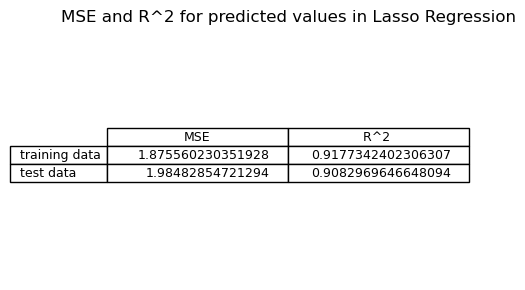

In [505]:
#retraining the model with the optimal value of k
knn_predict = predict(X, y, X_test, k=best_k)
print(f"MSE and R^2 statistics: {MSE(y_test, knn_predict)}, {Rsquare(y_test, knn_predict)}")

MSE_list_models.append(MSE(y_test, knn_predict))
R_square_list_models.append(Rsquare(y_test, knn_predict))
model_list.append("KNN test")

plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.transpose(np.array((MSE_preds, R_preds)))
columns = ("MSE", "R^2 ")
rows = ("training data", "test data")
axs.axis('tight')
axs.axis('off')
axs.set_title("MSE and R^2 for predicted values in Lasso Regression")
the_table = axs.table(cellText=data, colLabels=columns, rowLabels = rows, loc='center')
plt.show()

The value of R^2 in KNN regression is the smallest out of all methods with lasso performing the best, followed by elastic nets and then least squares. Note that the difference in R^2 between lasso, elastic nets and least squares is very small however KNN largely underperforms these learning methods and this suggests that the relationship between the predictor variables and the output variable is a strong linear one which is being well captured by these models and if it had been a non-linear relationship then KNN would have performed better than it did. 

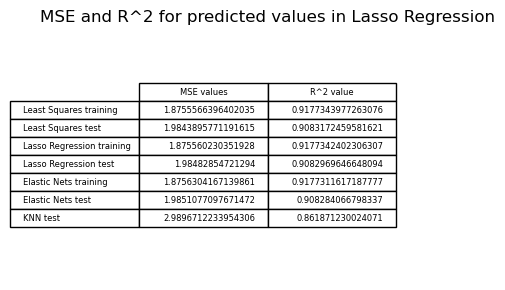

In [506]:
plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.transpose(np.array((MSE_list_models, R_square_list_models)))
columns = ("MSE values", "R^2 value")
rows = (model_list)
axs.axis('tight')
axs.axis('off')
axs.set_title("MSE and R^2 for predicted values in Lasso Regression")
the_table = axs.table(cellText=data, colLabels=columns, rowLabels = rows, loc='center')
plt.show()

## Task 2: Classification  (50 marks)



#### 2.1 Random forest (20 marks)
2.1.1

We now move onto classifying using random forests which is to predict whether someone is diabetic or not. Random forests will split the data iteratively based on which predictor variable gives it the most information (in this case we use the cross entropy to measure this).

In [6]:
#Loading in the data
diabetes_samples = pd.read_csv("diabetes_samples.csv")
unconverted_Y = np.array(diabetes_samples["diabetes"])
X_df = diabetes_samples.drop("diabetes", axis = 1)
RF_X = np.array(diabetes_samples)[:, 1:-1] #Removing the Y-variable

#We use 0 to identify a non-diabetic and 1 to identify a diabetic 
RF_y = np.array([(0) if z == "No diabetes" else 1 for z in unconverted_Y ])

#Convert ratio string variables into floats
#Convert ratio string variables into floats
for i in range(np.shape(RF_X)[0]):
   for j in [3, 7, 12]:
    RF_X[i, j] = float(RF_X[i, j].replace(",", "."))



diabetes_test = pd.read_csv("diabetes_test.csv")
unconverted_Y_test = np.array(diabetes_test["diabetes"])
RF_y_test = np.array([(0) if z == "No diabetes" else 1 for z in unconverted_Y_test ])
RF_X_test = np.array(diabetes_test)[:, 1:-1] #Removing the Y-variable

#Convert ratio string variables into floats for test data 
for i in range(np.shape(RF_X_test)[0]):
   for j in [3, 7, 12]:
    RF_X_test[i, j] = float(RF_X_test[i, j].replace(",", "."))


def cross_entropy(y, sample_weights):

  """ 
  Calculate the Cross Entropy for labels.
  Arguments:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (float): the Cross Entropy for y.
  """

  # count different labels in y，and store in label_weights
  # initialize with zero for each distinct label.
  label_weights = {yi: 0 for yi in set(y)}  
  for yi, wi in zip(y, sample_weights):
      label_weights[yi] += wi

  total_weight = sum(label_weights.values())
  entropy = 0
  for label, weight in label_weights.items():
      pi = weight/total_weight
      entropy -= (pi)*np.log(pi)


  return entropy

def CE_split_samples(X, y, sample_weights, column, value):
  """
  Return the split of data whose column-th feature:
    less than value

  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for splitting.
      value: splitting threshold  the samples 
      categorical: boolean value indicating whether column is a categorical variable or numerical.
  Returns:
      tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
  """ 
  left_mask = (X[:, column] < value)
  
  X_left, X_right = X[left_mask, :], X[~left_mask, :]
  y_left, y_right = y[left_mask], y[~left_mask]
  w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

  return (X_left, X_right), (y_left, y_right), (w_left, w_right)


def CE_split_value(X, y, sample_weights, column):
  """
  Calculate the cross entropy based on `column` with the split that minimizes the CE.
  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
  Returns:
      (float, float): the resulting CE and the corresponding value used in splitting.
  """
  
  unique_vals = np.unique(X[:, column])

  assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

  CE_val, threshold = np.inf, None
  
  # split the values of i-th feature and calculate the cost 
  for value in unique_vals:
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = CE_split_samples(X, y, sample_weights, column, value)

    #if one of the two sides is empty, skip this split. No gain of information
    if len(y_l) == 0 or len(y_r) == 0:
        continue

    p_left = sum(w_l)/(sum(w_l) + sum(w_r)) #Weight of left side of split
    p_right = 1 - p_left #Weight of right side of split
    new_cost = p_left * cross_entropy(y_l, w_l) + p_right*cross_entropy(y_r, w_r)
    #Finding the value which minimises the cross entropy by checking against every unique value in the coloumn
    if new_cost < CE_val:  
        CE_val, threshold = new_cost, value
    
  return CE_val, threshold

# UPDATED at 20:41 on 2/2/2022.

## Loops over coloumns to find the best column to split over and then the best value in that column 
def CE_split(X, y, sample_weights):
  """
  Choose the best feature to split according to criterion.
  Args:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (int, float): the best feature index and value used in splitting.
        If the feature index is None, then no valid split for the current Node.
  """

    #initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
  min_CE, split_column, split_val = np.inf, None, 0
  for column in range(np.shape(X)[1]):
      # skip column if samples are not seperable by that column.
      if len(np.unique(X[:, column])) < 2:
          continue

      ce, val = CE_split_value(X, y, sample_weights, column)          
      if ce < min_CE:
          min_CE, split_column, split_val = ce, column, val

  return split_column, split_val

def majority_vote(y, sample_weights):
  """
  Return the label which appears the most in y.
  Args:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (int): the majority label
  """
  majority_label = {yi: 0 for yi in set(y)}

  for yi, wi in zip(y, sample_weights):
    majority_label[yi] += wi
    #Return max value
  return max(majority_label, key=majority_label.get)


def build_tree_rf(n_features, X, y, sample_weights, feature_names, depth,  max_depth=10, min_samples_leaf=2):
  """Build the decision tree according to the data.
  Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
  Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
      Example:
          mytree = {
              'feature_name': 'petal length (cm)',
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
  """
  # include a clause for the cases where (i) no feature, (ii) all lables are the same, (iii) depth exceed, or (iv) X is too small
  if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf: 
      return {'majority_label': majority_vote(y, sample_weights)}
  
  min_CE, split_index, split_val = CE_split_rf(X, y, sample_weights)

  #If no valid split at this node, use majority vote.
  if split_index is None:
    return {'majority_label': majority_vote(y, sample_weights)}

  (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val)
  return {
      'feature_name': feature_names[split_index],
      'feature_index': split_index,
      'value': split_val,
      'majority_label': None,
      'left': build_tree_rf(n_features, X_l, y_l, w_l, feature_names, depth + 1, max_depth, min_samples_leaf),
      'right': build_tree_rf(n_features, X_r, y_r, w_r, feature_names, depth + 1, max_depth, min_samples_leaf)
  }

# EDIT THIS FUNCTION
def build_tree_rf(n_features, X, y, sample_weights, feature_names, max_depth, depth, min_samples_leaf=2):
  """Build the decision tree according to the data.
  Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
  Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
      Example:
          mytree = {
              'feature_name': 'petal length (cm)',
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
  """
  # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
  if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
      return {'majority_label': majority_vote(y, sample_weights)}
  
  else:
    CE, split_index, split_val = CE_split_rf(X, y, sample_weights)  
    
    # If CE is infinity then samples are not seperable by the sampled features.
    if CE == np.inf:
      return {'majority_label': majority_vote(y, sample_weights)}
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = CE_split_samples(X, y, sample_weights, split_index, split_val)
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'majority_label': None,
        'left': build_tree_rf(n_features, X_l, y_l, w_l, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree_rf(n_features, X_r, y_r, w_r, feature_names, depth + 1, max_depth, min_samples_leaf)
    }
  
def train_rf(X, y, n_features, feature_names, B, max_depth, sample_weights=None):
  """
  Build the decision tree according to the training data.
  Args:
      B: number of decision trees.
      n_features: number of sampled features.

      X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
      y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      sample_weights: weights for each samples, of shape (N,).
  """
  if sample_weights is None:
      # if the sample weights is not provided, we assume the samples have uniform weights
      sample_weights = np.ones(X.shape[0]) / X.shape[0]
  else:
      sample_weights = np.array(sample_weights) / np.sum(sample_weights)

 
  N = X.shape[0]
  training_indices = np.arange(N)
  trees = []

  for _ in range(B):
    sample = np.random.choice(training_indices, N, replace=True)
    X_sample = X[sample, :]
    y_sample = y[sample]
    w_sample = sample_weights[sample]
    tree = build_tree_rf(n_features, X_sample, y_sample, w_sample, feature_names, max_depth, depth=1, min_samples_leaf=2 )
    trees.append(tree)

  return trees


def classify(tree, x):
  """
  Classify a single sample with the fitted decision tree.
  Args:
      x: ((pd.Dataframe) a single sample features, of shape (D,).
  Returns:
      (int): predicted testing sample label.
  """
  if tree['majority_label'] is not None: 
    return tree['majority_label']

  else:
    if x[tree['feature_index']] < tree['value']:
      return classify(tree['left'], x)
    else:
      return classify(tree['right'], x)
  
def predict_rf(rf, X):
  """
  Predict classification results for X.
  Args:
      rf: A trained random forest through train_rf function.
      X: (pd.Dataframe) testing sample features, of shape (N, D).
  Returns:
      (np.array): predicted testing sample labels, of shape (N,).
  """
  def aggregate(decisions):
    count = defaultdict(int)
    for decision in decisions:
      count[decision] += 1
    return max(count, key=count.get)

  if len(X.shape) == 1:
      return aggregate([classify(tree, X) for tree in rf])
  else:
      return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

def accuracy(rf, X_test, y_test):
  y_pred = predict_rf(rf, X_test) 
  return np.mean(y_pred==y_test)

def CE_split_rf(X, y, sample_weights):
  """
  Choose the best feature to split according to criterion.
  Args:
      n_features: number of sampled features.
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
  Returns:
      (float, int, float): the minimized cross entropy, the best feature index and value used in splitting.
  """
  min_CE, split_column, split_val = np.inf, 0, 0
  for column in range(np.shape(X)[1]):
    # skip column if samples are not seperable by that column.
    if len(np.unique(X[:, column])) < 2:
      continue

    # search for the best splitting value for the given column.
    ce, val = CE_split_value(X, y, sample_weights, column)  
    if ce < min_CE:
        min_CE, split_column, split_val = ce, column, val

  return min_CE, split_column, split_val

def grid_search(y, X, n_features, feature_names, folds, num_trees, depth_vals, sample_weights, k=4):
    best_vals = []
    best_val = 0
    for n in num_trees:
        for d in depth_vals:
            #Score for a given (l, a)
            perform_val = cross_val(y, X, n_features, feature_names, folds, n, d, sample_weights, k=4)
            #update to find smallest MSE
            if perform_val > best_val:
                best_val = perform_val
                best_d = d
                best_n = n
    best_vals.append(best_n)
    best_vals.append(best_d)
    return best_vals

def cross_val(Y, X, n_features, feature_names, folds, num_trees, max_depth, sample_weights, k=4):
    score = 0
    for i in range(len(folds)):
        #One of the folds picked as a validation set
        val_indexes = folds[i]
        #The rest of the folds are left as training sets
        train_indexes = list(set(range(Y.shape[0])) - set(val_indexes))
        
        X_train_i = X[train_indexes, :]
        y_train_i = Y[train_indexes]

        X_val_i = X[val_indexes, :] 
        y_val_i = Y[val_indexes] 

        forest = train_rf(X_train_i, y_train_i, n_features, feature_names, num_trees, max_depth, sample_weights)
        perform_val = accuracy(forest, X_val_i, y_val_i) 

        score += perform_val
    # Return the average score
    return score/len(folds)

feature_names = diabetes_samples.columns.tolist()[1:-1]
n_features = len(feature_names)
folds_indexes4 = np.array_split(np.arange(len(RF_y)), 4)
num_trees = np.arange(1, 10)
depth_vals = np.arange(1, 10)
optimal_vals = grid_search(RF_y, RF_X, n_features, feature_names, folds_indexes4, num_trees, depth_vals, sample_weights = None, k=4)


2.1.2

Optimal values for the maximum number of trees and depth: 1, 5


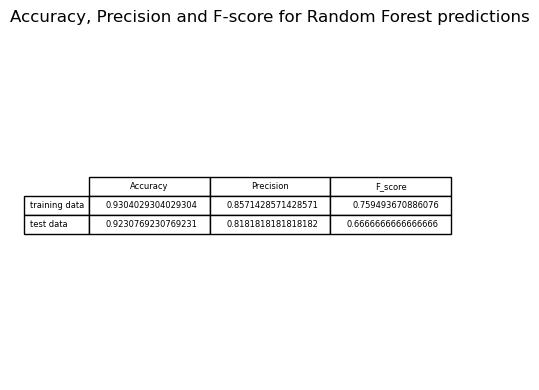

In [7]:
def TP_val(y_test, y_pred):
   return np.dot(y_pred, y_test)

def FP_val(y_test, y_pred):
   y_flip = np.ones(len(y_test)) - y_test
   return np.dot(y_pred, y_flip)

def accuracy1(y_test, y_pred):
  return np.mean(y_test == y_pred)

def precision(y_test, y_pred):
   TP = TP_val(y_test, y_pred)
   FP = FP_val(y_test, y_pred)
   return (TP)/(TP+FP)

def F_score(y_test, y_pred):
   TP = TP_val(y_test, y_pred)
   P = np.sum(y_test)
   recall = TP/P
   prec = precision(y_test, y_pred)
   return 2* prec * recall / (prec + recall)

forest = train_rf(RF_X, RF_y, n_features, feature_names, optimal_vals[0], optimal_vals[1], sample_weights=None)
RF_y_pred = predict_rf(forest,RF_X)
RF_y_pred_test = predict_rf(forest, RF_X_test)

#Store values for a table
RF_acc = [accuracy1(RF_y, RF_y_pred), accuracy1(RF_y_test, RF_y_pred_test)]
RF_prec = [precision(RF_y, RF_y_pred), precision(RF_y_test, RF_y_pred_test)]
RF_Fscore = [F_score(RF_y, RF_y_pred), F_score(RF_y_test, RF_y_pred_test)]

print(f"Optimal values for the maximum number of trees and depth: {optimal_vals[0]}, {optimal_vals[1]}")

#TABLE
plt.rcParams["figure.figsize"] = [5, 4]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.transpose(np.array((RF_acc, RF_prec, RF_Fscore)))
columns = ("Accuracy", "Precision", "F_score")
rows = ("training data", "test data")
axs.axis('tight')
axs.axis('off')
axs.set_title("Accuracy, Precision and F-score for Random Forest predictions")
the_table = axs.table(cellText=data, colLabels=columns, rowLabels = rows, loc='center')
plt.show()


Considering the real world applications of this data we would want to identify as many of the true positives (people who actually have diabetes) as possible. We can easily intepret accuracy as us correctly identifying as many people as possible as diabetic or non-diabetic. An interpretation of precision is that if we have a precision of 0.8 then 80% of the patients predicted to be diabetic are in fact diabetic, this would be an important metric to try and maximise since we do not want diabetic patients to be left untreated. The F-score allows us to balance the tradeoff between the TPR and precision, it allows us to maximally identify truly diabetic patients as well as minimise the number of non-diabetic patients being diagnosed as diabetic, something that we would probably be more open to not maximising since non-diabetic patients can be screened out in further tests. 


As we would expect we see that the training set performs better than the test set and this is because random forests and decision trees are very susceptible to overfitting. Despite having used optimised parameters we still manage to overfit the model quite substantially (big differences in statistics) and so it could be that our predictor variables are not good indicators of diabetes and so the model is finding it difficult to split the data well. Another issue could be that we simply do not have enough data observations and so we would need to increase the size of the training set for better performance. Something to keep in mind is that the majority of the observations have outcome variable 0 (non-diabetic) and so our model is biased in this sense. Our large accuracy can be explained from this since even predicting all outcome variables as 0 would result in a high true negative rate and thus a high accuracy. 

2.1.3

In [9]:
print(f"frequency of positive outcomes {np.sum(RF_y)/len(RF_y)}")

#Weight function for bootstrap method
def weights(y_train):
   N = len(y_train)
   ones = np.sum(y_train == np.ones(N))
   zeros = np.sum(y_train == np.zeros(N))
   weights = (zeros/N) * y_train
   zeros_into_ones = np.ones(N) - y_train
   weights += ones/N * zeros_into_ones
   return weights 

#Finding the optimal values for the weighted bootstrap method
weighted_vals = weights(RF_y)
weighted_optimals = grid_search(RF_y, RF_X, n_features, feature_names, folds_indexes4, num_trees, depth_vals, weighted_vals, k=4)
weighted_forest = train_rf(RF_X, RF_y, n_features, feature_names, weighted_optimals[0], weighted_optimals[1], weighted_vals)


frequency of positive outcomes 0.16117216117216118


[2, 2]


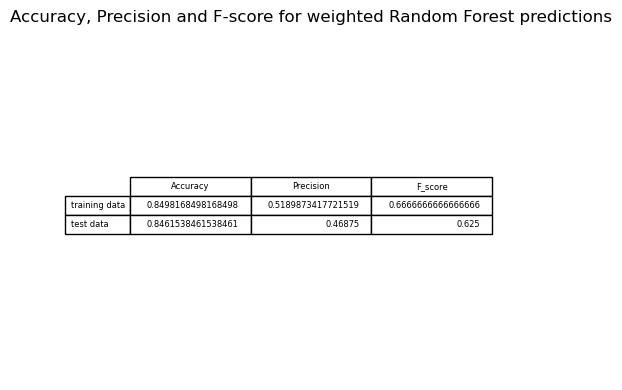

Text(0.5, 1.0, 'Precision-Recall graph for random forest')

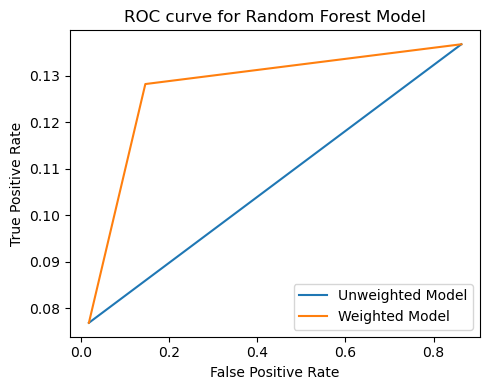

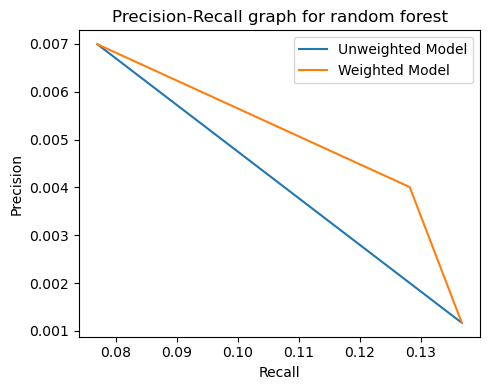

In [10]:
print(weighted_optimals)

#weighted RF predictions
RF_weight_y_pred = predict_rf(weighted_forest,RF_X)
RF_weight_y_pred_test = predict_rf(weighted_forest, RF_X_test)

RF_acc_weighted = [accuracy1(RF_y, RF_weight_y_pred), accuracy1(RF_y_test, RF_weight_y_pred_test)]
RF_prec_weighted = [precision(RF_y, RF_weight_y_pred), precision(RF_y_test, RF_weight_y_pred_test)]
RF_Fscore_weighted = [F_score(RF_y, RF_weight_y_pred), F_score(RF_y_test, RF_weight_y_pred_test)]

#TABLE
plt.rcParams["figure.figsize"] = [5, 4]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.transpose(np.array((RF_acc_weighted, RF_prec_weighted, RF_Fscore_weighted)))
columns = ("Accuracy", "Precision", "F_score")
rows = ("training data", "test data")
axs.axis('tight')
axs.axis('off')
axs.set_title("Accuracy, Precision and F-score for weighted Random Forest predictions")
the_table = axs.table(cellText=data, colLabels=columns, rowLabels = rows, loc='center')
plt.show()


def ROC(X_train, y_train, X_test, y_test, feature_names, n_features, num_trees, max_depth, thresholds, sample_weights):
  TPR = []
  FPR = []
  prec = []
  n = len(y_test)
  forest = train_rf(X_train, y_train, n_features, feature_names, num_trees, max_depth, sample_weights)
  #intial y stores the mean of the rows of the trees and final y compares its entries to the threshold value
  initial_y, final_y = np.zeros(n), np.zeros(n)
  for i in range(len(thresholds)):
    #list to store predictions
    tree_list = np.zeros((n, len(forest)))
    for j in range(len(forest)):
        tree_list[:, j] = predict_rf([forest[j]], X_test)
    initial_y = tree_list.mean(axis = 1)

    for k in range(len(initial_y)):
      #Compares enteries with threshold to determine how to classify observation k
      if initial_y[k] >= thresholds[i]:
        final_y[k] = 1
      else: 
        final_y[k] = 0
    TPR_val = TP_val(y_test, final_y) / len(y_test)
    FPR_val = FP_val(y_test, final_y) / len(y_test)
    prec_val = precision(y_test, final_y) / len(y_test)

    TPR.append(TPR_val)
    FPR.append(FPR_val)
    prec.append(prec_val)
  return TPR, FPR, prec
threshold_vals = np.linspace(0, 1, 10)
TPR, FPR, prec = ROC(RF_X, RF_y, RF_X_test, RF_y_test, feature_names, n_features, optimal_vals[0], optimal_vals[1], threshold_vals, sample_weights=None)
TPR_weight, FPR_weight, prec_weight = ROC(RF_X, RF_y, RF_X_test, RF_y_test, feature_names, n_features, weighted_optimals[0], weighted_optimals[1], threshold_vals, weighted_vals)


plt.figure()
plt.plot(FPR, TPR, label ="Unweighted Model")
plt.plot(FPR_weight, TPR_weight, label="Weighted Model")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest Model")

plt.figure()
plt.plot(TPR, prec, label ="Unweighted Model")
plt.plot(TPR_weight, prec_weight, label="Weighted Model")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall graph for random forest")

We see that the under the weighted tree we gain an improvement in the accuracy which is something we would expect as the bootstrap samples will contain more 1's than the original training data. We would expect a decrease in the precision and F score since.

The ROC curve is able to tell us the predicitive power of the model. We would want our model to be above the y=x line which represents the predicitive power of the null model. A model below this line should be discarded since it would be better to not predict using this model. 

The precision recall graph represents the tradeoff between precision and recall. In this curve, like the ROC curve we vary the threshold value from 0 to 1. Using contextual information we would then need to decide where to make this cut off, and this would vary heavily based on the use-case. For example a deadly disease would want to be captured with very high precision. 

#### 2.2	Support Vector Machine (SVM) (30 marks)
2.2.1

SVM's aim to seperate the data and so we will now try this method in order to classify the samples. We will use both kernalised and linear SVM's since kernalised SVM's is better able to find non-linear relationships and then seperate based on this.

In [11]:
#Loading in the data
diabetes_samples = pd.read_csv("diabetes_samples.csv")
unconverted_Y = np.array(diabetes_samples["diabetes"])

#data array
SVM_X = RF_X.copy()
#We use -1 to identify a non-diabetic and 1 to identify a diabetic 
SVM_y = np.array([(-1) if z == "No diabetes" else 1 for z in unconverted_Y ])

#Test data
SVM_y_test = np.array([(-1) if z == "No diabetes" else 1 for z in unconverted_Y_test ])
SVM_X_test = RF_X_test.copy()


SVM_X, mu1, sigma1 = standardise(SVM_X.astype(float))
data_split = np.hstack((SVM_X, SVM_y[:, np.newaxis]))
SVM_X_test = (SVM_X_test - mu1)/sigma1

# insert 1 in every row for intercept b and used for cross validation
SVM_X1 = np.hstack((SVM_X, np.ones((len(SVM_X),1)) ))
SVM_X_test1= np.hstack((SVM_X_test, np.ones((len(SVM_X_test),1)) )) 
SVM_y = SVM_y.astype(float)

In [12]:
def SVM_loss(w, X, y, regul_strength=1e5):
  distances = 1 - y * (X @ w) 
  distances[distances < 0] = 0  
  hinge = regul_strength * np.sum(distances)
  # calculate loss
  return 0.5 * np.dot(w, w) + hinge

# calculate grad of loss
def calculate_cost_gradient(w, X_batch, y_batch, l):
  # if only one example is passed
  if type(y_batch) == np.float64:
      y_batch = np.asarray([y_batch])
      X_batch = np.asarray([X_batch]) 

  distance = 1 - (y_batch * (X_batch @ w))
  dw = np.zeros(len(w))
  
  we = w.copy()
  we[-1] = 0 # Not changing b
  for ind, d in enumerate(distance):
      if max(0, d)==0:
          di = we # derivative of first term
      else:
          di = we - (l * y_batch[ind] * X_batch[ind])
      dw += di

  return dw/len(y_batch)  # average

def sgd(X, y, l, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, print_outcome=False):
  
  # initialise zero weights
  weights = np.zeros(X.shape[1])
  nth = 0
  # initialise starting cost as infinity
  prev_cost = np.inf
  
  # stochastic gradient descent
  indices = np.arange(len(y))

  for iteration in range(1, max_iterations):
    # shuffle to prevent repeating update cycles
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]
    
    for xi, yi in zip(X, y):
      descent = calculate_cost_gradient(weights, xi, yi, l) 
      weights = weights - (learning_rate * descent)

    # convergence check on 2^n'th iteration
    if iteration==2**nth or iteration==max_iterations-1:
      # compute cost
      cost = SVM_loss(weights, X, y, l)  
      if print_outcome:
        print("Iteration is: {}, Cost is: {}".format(iteration, cost))
      # stop criterion
      if abs(prev_cost - cost) < stop_criterion * prev_cost:
        return weights
        
      prev_cost = cost
      nth += 1
  
  return weights

def SVM_score(w, X, y):
  y_preds = np.sign(X @ w)
  return np.mean(y_preds == y) 

def cross_val_split(N, num_folds):
  fold_size = N // num_folds
  index_perm = np.random.permutation(np.arange(N))
  folds = []
  for k in range(num_folds):
    folds.append(index_perm[k*fold_size:(k+1)*fold_size])
  return folds

def cross_val_evaluate(data, num_folds, l):
  folds = cross_val_split(data.shape[0], num_folds)

  val_scores = []
  for i in range(len(folds)):
    val_indices = folds[i]
    # define the training set
    train_indices = list(set(range(data.shape[0])) - set(val_indices))

    X_train = data[train_indices,  :-1]  
    y_train = data[train_indices, -1]
    
    # define the validation set
    X_val = data[val_indices,  :-1]  
    y_val = data[val_indices, -1]  

    # train the model
    w = sgd(X_train, y_train, l, max_iterations=1025, stop_criterion=0.01, learning_rate=1e-5)
  
    val_score = SVM_score(w, X_val, y_val)
    #print("Accuracy on validation set #{}: {}".format(i+1, val_score))

    val_scores.append(val_score)

  return np.mean(np.array(val_scores)), w

#Put the X and y into one array
data = np.c_[SVM_X1, SVM_y]

#Values of lambda to test
lam_vals = np.arange(0, 10)

#Scores 
val_scores = []

#List of w vectors
W = []
for i in range(len(lam_vals)):
  val_score, w = (cross_val_evaluate(data, 4, 10**(lam_vals[i])))
  val_scores.append(val_score)
  W.append(w)

2.2.2

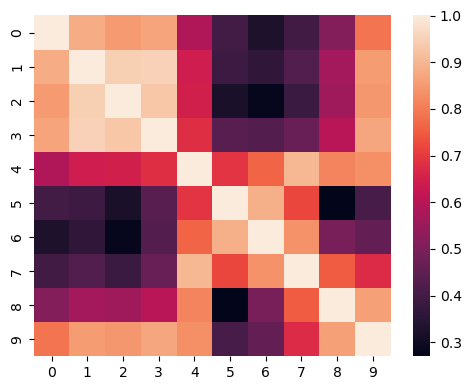

In [13]:
import seaborn as sns
#Cosine between two vectors is a multiple of the dot product and the length of the vectors
def cos_func(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

w_vecs = list(W)
#Cosine matrix should be symmetric
cos_mat = np.array([[cos_func(w_vecs[i], w_vecs[j]) for i in range(len(w_vecs))] for j in range(len(w_vecs))])

#Plot the heatmap
heatmap = sns.heatmap(cos_mat)



A larger value of lambda results in a higher penalty for misclassification, which means the algorithm will prioritize finding a smaller margin that separates the classes with fewer misclassifications. In contrast, a smaller value of lambda results in a lower penalty for misclassification, which means the algorithm will prioritize finding a larger margin even if that margin results in more misclassifications.

In this case lambda helps us balance the bias-variance tradeoff which will result in a well-generalized model with good predictive performance.

We can then interpret this heatmap as representing the fact that highervalues of lambda results in smaller margins which are likely to be at right angles to each other in the space and so their cosine is nearing 0, and vice versa for smaller values of lambda. Of course the cosine of an angle with itself is 0 and so the diagonal values are all white.

A low hardness SVM makes the model more tolerant to noise or outliers in the data, and can result in a simpler decision boundary that generalizes better to unseen data. However, a low hardness SVM may also be prone to underfitting, as it may not capture the underlying patterns in the data. A high hardness SVM is less tolerant to noise or outliers in the data, and can result in a more complex decision boundary that is prone to overfitting. However, a high hardness SVM may also perform well on highly separable data, as it captures the underlying patterns in the data more precisely.



2.2.3

Optimal value of lambda: 10


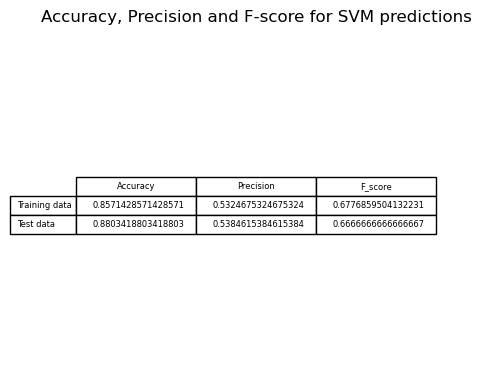

In [14]:
optimal_l = 10**val_scores.index(max(val_scores))
print(f"Optimal value of lambda: {optimal_l}")
w = sgd(SVM_X, SVM_y, optimal_l)
SVM_y_pred = np.sign(SVM_X @ w)

#Statistics for the training set
#new y values with 0 instead of -1
SVM_y_new = SVM_y.copy()
SVM_y_new[SVM_y_new<0] = 0
SVM_y_pred[SVM_y_pred<0] = 0
SVM_acc = accuracy1(SVM_y_new, SVM_y_pred)
SVM_prec = precision(SVM_y_new, SVM_y_pred)
SVM_Fscore = F_score(SVM_y_new, SVM_y_pred)


#Statistics for the test set 
SVM_y_pred_test = np.sign(SVM_X_test @ w)
SVM_y_test_new = SVM_y_test.copy()

SVM_y_test_new[SVM_y_test_new<0] = 0
SVM_y_pred_test[SVM_y_pred_test<0] = 0

SVM_test_acc = accuracy1(SVM_y_test_new, SVM_y_pred_test)
SVM_test_prec = precision(SVM_y_test_new, SVM_y_pred_test)
SVM_test_Fscore = F_score(SVM_y_test_new, SVM_y_pred_test)


plt.rcParams["figure.figsize"] = [5, 4]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.transpose(np.array(([SVM_acc, SVM_test_acc], [SVM_prec, SVM_test_prec], [SVM_Fscore, SVM_test_Fscore])))
columns = ("Accuracy", "Precision", "F_score")
rows = ("Training data", "Test data")
axs.axis('tight')
axs.axis('off')
axs.set_title("Accuracy, Precision and F-score for SVM predictions")
the_table = axs.table(cellText=data, colLabels=columns, rowLabels = rows, loc='center')
plt.show()


2.2.4

In [15]:
# Kernel function
def kernel_matrix(X1,X2,sigma):

    n1,m1 = X1.shape
    n2,m2 = X2.shape
    kernel = np.zeros((n1,n2))

    # Here we define the sigmoid Kernel #
    for i in range(n1):
        for j in range(n2):
            kernel[i][j] = np.tanh(sigma * np.dot(X1[i], X2[j]) +1 )
    return kernel

def compute_cost_kernel(u, K, y, l,b=0):

    # Here I define the hinge cost with the kernel trick.
    
    distances = 1 - (y)*(K@u + b) 
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = l * distances.mean()

    # calculate cost
    return 0.5 * np.dot(u,K@u) + hinge

def calculate_cost_gradient_kernel(u, K_batch, y_batch, l=1e3,b=0):

    # if only one example is passed
    if type(y_batch) == np.float64 or type(y_batch) == np.int32:
        y_batch = np.asarray([y_batch])
        K_batch = np.asarray([K_batch])  # gives multidimensional array
    
    distance = 1 - (y_batch * (K_batch @ u + b)) 
    dw = np.zeros(len(u) + 1)

    # define the gradient with the hinge loss 
    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = K_batch@u 
            db = 0
        else:
            di = K_batch@u - (l * y_batch[ind] * K_batch[ind]) 
            db = -l*y_batch[ind]
        dw[:-1] += di
        dw[-1] += db

    return dw/len(y_batch)

def sgd_kernel(K, y, batch_size=32, max_iterations=4000, stop_criterion=0.001, learning_rate=1e-4, l=1e3, print_outcome=False):

    # initialise zero u and intercept
    u = np.zeros(K.shape[1])
    b=0
    
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        K_b, y_b = K[batch_idx], y[batch_idx]
        for ki, yi in zip(K_b, y_b):
            cost_grad = calculate_cost_gradient_kernel(u, ki, yi, l, b)
            ascent, ascent_intercept = cost_grad[:-1], cost_grad[-1]
            u = u - (learning_rate * ascent)
            b = b - (learning_rate * ascent_intercept)
        
        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost_kernel(u, K, y, l, b)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return u, b
            
            prev_cost = cost
            nth += 1
    
    return u, b

def score(u, T, y, sigma, b):
    #Kernel for test and training data
    K_test = kernel_matrix(T,SVM_X, sigma)
    
    ## The 
    y_preds = np.sign(K_test@u + b) 
    y_preds[y_preds < 0] = 0 #convert -1 to 0 to get correct accuracy score
    return np.mean(y_preds == y), precision(y, y_preds), F_score(y, y_preds)

b_vals = []

for sigma in [0.01, 0.1, 1, 2]:
    K_train = kernel_matrix(SVM_X,SVM_X, sigma)
    u,b = sgd_kernel(K_train, SVM_y, batch_size=128, max_iterations=2000, stop_criterion=0.001, learning_rate=1e-5, l= 10, print_outcome=False)
    b_vals.append(b)

    SVM_kernel_acc, SVM_kernel_prec, SVM_kernel_fscore = score(u, SVM_X, SVM_y_new, sigma, b)
    SVM_kernel_acc_test, SVM_kernel_prec_test, SVM_kernel_fscore_test = score(u, SVM_X_test, SVM_y_test_new, sigma, b)

    print(f"accuracy for sigma ={sigma} on the training set: {SVM_kernel_acc}")
    print(f"precision for sigma ={sigma} on the training set: {SVM_kernel_prec}")
    print(f"F-score for sigma ={sigma} on the training set: {SVM_kernel_fscore}")
    print(f"accuracy for sigma ={sigma} on the test set: {SVM_kernel_acc_test}")
    print(f"precision for sigma ={sigma} on the test set: {SVM_kernel_prec_test}")
    print(f"F-score for sigma ={sigma} on the test set: {SVM_kernel_fscore_test}")


print(f"values of b {b_vals} for sigma 0.01, 0.1, 1, 2 respectively")



/var/folders/zh/7zp_8xb91cj2g3jy1m3w7kp40000gn/T/ipykernel_11833/1600770335.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return (TP)/(TP+FP)


accuracy for sigma =0.01 on the training set: 0.8388278388278388
precision for sigma =0.01 on the training set: nan
F-score for sigma =0.01 on the training set: nan
accuracy for sigma =0.01 on the test set: 0.8632478632478633
precision for sigma =0.01 on the test set: nan
F-score for sigma =0.01 on the test set: nan
accuracy for sigma =0.1 on the training set: 0.9340659340659341
precision for sigma =0.1 on the training set: 0.8823529411764706
F-score for sigma =0.1 on the training set: 0.7692307692307693
accuracy for sigma =0.1 on the test set: 0.9230769230769231
precision for sigma =0.1 on the test set: 0.8181818181818182
F-score for sigma =0.1 on the test set: 0.6666666666666666
accuracy for sigma =1 on the training set: 0.9853479853479854
precision for sigma =1 on the training set: 0.9761904761904762
F-score for sigma =1 on the training set: 0.9534883720930233
accuracy for sigma =1 on the test set: 0.9230769230769231
precision for sigma =1 on the test set: 0.7333333333333333
F-score

2.2.5

The kernalised SVM is better able to capture non-linear patterns in the data and so it will therefore have better results (in terms of statistics measured) for these values. We compare the results from the linear SVM with the kernalised ones and find that this actually performs better on the data which means that there is a non-linear relationship that the kernalised method is able to capture. 